In [84]:
from copy import copy
import math
import random
import numpy as np
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [85]:
GRID_SIZE = 15
EPISODES = 4000
MAX_STEPS = 500

ACTIONS = ['up', 'right', 'down', 'left']
ACTION_IDX = {a: i for i, a in enumerate(ACTIONS)}

START_POS = (2, 7)
GOAL_POS = (14, 7)
OBSTACLE_START = (11, 7)  # スタートの真下
REWARD_MAX = 10
REWARD_MIN = -10
LOSS = -8

ALPHA = 0.1
GAMMA = 0.99
STEP_PENALTY = -0.1

In [86]:
class Environment:
    def __init__(self):
        #setting dataset
        self.row = GRID_SIZE
        self.line = GRID_SIZE
        self.map = np.zeros((self.row, self.line))
        self.g_pos = GOAL_POS
        self.s_pos = START_POS
        self.map[self.g_pos] = 2
        self.map[self.s_pos] = -1
        self.r = GAMMA
        self.a = ALPHA
        num_actions = 4 # 上下左右の4方向
        
        self.obstacle_pos = np.array(OBSTACLE_START)
        self.obstacle_size = np.array([1, 1])
        self.map[tuple(self.obstacle_pos)] = 1
        self.next_obstacle_pos = None
        self.d_min = 4.0  # 危険状態と判断する距離
        self.d_col = 1.5  # 衝突と判断する距離 (少し厳しく)


        num_rg = 4  # ゴールの相対領域 (上, 右, 下, 左)
        num_ro = 4  # 障害物の相対領域 (上, 右, 下, 左)
        num_actions = 8 # 司令塔が出す目標方位 (8方位)
        self.Qtable = np.zeros((num_rg, num_ro, num_actions))


    def get_state_type(self, agent_pos, obstacle_pos):
        """現在の状態が安全(SS)か危険(NS)かなどを判定する"""
        if np.array_equal(agent_pos, self.g_pos):
            return "WS"  # Winning State
        dist_ro = np.linalg.norm(agent_pos - obstacle_pos)
        if dist_ro <= self.d_col:
            return "FS"  # Failure State (衝突)
        if dist_ro <= self.d_min:
            return "NS"  # Non-safe State (危険)
        return "SS"  # Safe State (安全)

    def update_obstacle(self):
        # 次の位置を計算
        next_pos = self.obstacle_pos.copy()
        if next_pos[0] > 0:
            next_pos[0] -= 1
        self.next_obstacle_pos = next_pos

    def apply_obstacle_update(self):
        # 旧位置を消去
        pos = self.obstacle_pos
        if 0 <= pos[0] < self.row and 0 <= pos[1] < self.line:
            if (pos[0], pos[1]) != self.g_pos and (pos[0], pos[1]) != self.s_pos:
                self.map[tuple(pos)] = 0
        # 新位置を反映
        self.obstacle_pos = self.next_obstacle_pos
        pos = self.obstacle_pos
        if 0 <= pos[0] < self.row and 0 <= pos[1] < self.line:
            if (pos[0], pos[1]) != self.g_pos and (pos[0], pos[1]) != self.s_pos:
                self.map[tuple(pos)] = 1
    
    def get_abstract_state(self, agent_pos, obstacle_pos, goal_pos):
        """【翻訳機】具体的な座標から、Qテーブルで使える簡単な状態(Rg, Ro)を計算する。
        Rg: ゴールは4方位のどこか (0-3)
        Ro: 障害物は4方位のどこか (0-3)
        """
        # ゴールへのベクトル
        rel_g = goal_pos - agent_pos
        # 障害物へのベクトル
        rel_o = obstacle_pos - agent_pos
        
        # ベクトルの角度を計算し、0-3の4方位に変換
        Rg = int((math.atan2(-rel_g[0], rel_g[1]) * 180 / math.pi + 45) % 360 / 90)
        Ro = int((math.atan2(-rel_o[0], rel_o[1]) * 180 / math.pi + 45) % 360 / 90)
        
        return (Rg, Ro)

    #現状は使っても使わなくてもよい、複数に対応する用
    def update_obstacles(self):
        self.update_obstacle()

    def get_leader_map(self):
        return self.map

    def get_goal_pos(self):
        return self.g_pos

    def get_start_pos(self):
        return self.s_pos

    def Pr_ssa(self, at):
        thred = 0
        if random.uniform(0, 1) < thred:
            at = random.randint(0, 3)
        return at

    def calculate_reward(self, current_pos, current_obs_pos):
        if current_pos[0] < 0 or current_pos[0] >= self.row or current_pos[1] < 0 or current_pos[1] >= self.line:
            return REWARD_MIN
        
        #state reward
        current_state_type = self.get_state_type(current_pos, current_obs_pos)
        if current_state_type == "WS":
            return REWARD_MAX
        if current_state_type == "FS":
            return REWARD_MIN
        
        reward = 0
        
        # ステップペナルティ
        reward += STEP_PENALTY
        
        return reward

    def renew_Qtable(self, stp_abstract, st_abstract, at, reward):
        """Qテーブルを更新する (引数を抽象状態に変更)"""
        # 抽象状態 (Rg, Ro) をインデックスとして使用
        Rg_p, Ro_p = stp_abstract
        Rg, Ro = st_abstract
        Q_sa = self.Qtable[Rg_p, Ro_p, at]
        max_Q_s_prime = np.max(self.Qtable[Rg, Ro, :])
        new_Q_sa = Q_sa + self.a * (reward + self.r * max_Q_s_prime - Q_sa)
        self.Qtable[Rg_p, Ro_p, at] = new_Q_sa

        return new_Q_sa
    
    def check_crossing(self, agent_next_pos, obstacle_next_pos):
        # すれ違い禁止チェック
        agent_pos = np.array(agent_next_pos)
        obstacle_pos = np.array(obstacle_next_pos)
        
        # 現在位置と次の位置の組み合わせをチェック
        if (np.array_equal(agent_pos, obstacle_pos) or  # 同じ位置に移動
            (np.array_equal(agent_pos, self.obstacle_pos) and 
             np.array_equal(obstacle_pos, self.flock.pos_r))):  # すれ違い
            return True
        return False


In [87]:
class Flock:
    def __init__(self, start_pos=(2, 7), split=0.01, recognition_radius=2.5):
        self.pos_r = np.array(start_pos, dtype=float)
        self.prev_pos_r = np.array(start_pos, dtype=float)
        self.velocity_r = np.zeros(2)
        self.split_time = split
        self.epsilon = 0.1
        self.at = None
        self.recognition_radius = recognition_radius
        self.prev_obstacle_dist = None
        self.sum_reward = 0
        self.st = [int(start_pos[0]), int(start_pos[1])]
        self.stp = [int(start_pos[0]), int(start_pos[1])]
        self.next_pos = None  # 次の位置を保持

    def select_action(self, Qtable, st_abstract):
        """Q学習に基づいて行動を選択する (引数を抽象状態に変更)"""
        if random.uniform(0, 1) < self.epsilon:
            # 探索 (行動は8方位あると仮定)
            self.at = random.randint(0, 7)
        else:
            # 活用
            Rg, Ro = st_abstract # 抽象状態を分解
            q_values = Qtable[Rg, Ro, :] # 正しいインデックスでアクセス

            if np.all(q_values == 0):
                self.at = random.randint(0, 7)
            else:
                self.at = np.argmax(q_values)
                
    def set_leader_v(self):
        # 行動に応じて速度を設定
        if self.at == 0:  # up
            self.velocity_r = np.array([-1, 0])
        elif self.at == 1:  # right
            self.velocity_r = np.array([0, 1])
        elif self.at == 2:  # down
            self.velocity_r = np.array([1, 0])
        elif self.at == 3:  # left
            self.velocity_r = np.array([0, -1])
        else:
            self.velocity_r = np.zeros(2)

    def calculate_next_position(self):
        # 次の位置を計算
        next_pos = self.pos_r + self.velocity_r * self.split_time
        self.next_pos = next_pos

    def apply_movement(self):
        # 実際の移動を適用
        self.prev_pos_r = self.pos_r.copy()
        self.pos_r = self.next_pos

        
    

    def move(self, map_):
        prev_dist, _ = self.get_nearest_obstacle(map_)
        self.prev_obstacle_dist = prev_dist
        self.prev_pos_r = self.pos_r.copy()
        self.pos_r = self.pos_r + self.velocity_r * self.split_time
        after_dist, _ = self.get_nearest_obstacle(map_)
        reward = 0
        if self.prev_obstacle_dist is not None and after_dist is not None and self.prev_obstacle_dist > 0:
            ratio = after_dist / self.prev_obstacle_dist
            if ratio < 1.0:
                reward = -abs(1.0 - ratio)
            else:
                reward = 0
        else:
            reward = 0
        self.sum_reward += reward
        return reward

In [88]:
# --- 新規作成: DWAロジック関数 ---

def get_dwa_trajectories(current_pos, depth=3):
    """3~4手先までの全ての有効な移動パターン（軌跡）を生成する"""
    trajectories = []
    # (ここに軌跡を生成する再帰的な処理などを実装)
    # 例: path = [(y,x), (y,x), ...], trajectories = [path1, path2, ...]
    # 簡単な実装例
    q = [(list(current_pos), [])]
    visited = {tuple(current_pos)}

    while q:
        pos, path = q.pop(0)
        if len(path) == depth:
            trajectories.append(path)
            continue
        
        for action_idx, move in enumerate([(-1, 0), (0, 1), (1, 0), (0, -1)]):
            next_pos = (pos[0] + move[0], pos[1] + move[1])
            if 0 <= next_pos[0] < GRID_SIZE and 0 <= next_pos[1] < GRID_SIZE and next_pos not in visited:
                new_path = path + [action_idx]
                q.append((list(next_pos), new_path))
                visited.add(next_pos)
    return trajectories


def dwa_avoidance_step(current_pos, obstacle_pos, obstacle_v, goal_pos):
    """DWAの考え方に基づき、最適な次の1歩を決定する"""
    
    # 1. 軌跡候補の生成
    trajectories = get_dwa_trajectories(current_pos, depth=4) 
    
    safe_trajectories = []
    
    # 2. 衝突判定と枝刈り
    for path in trajectories:
        is_safe = True
        temp_pos = list(current_pos)
        for i, action_idx in enumerate(path):
            move = [(-1, 0), (0, 1), (1, 0), (0, -1)][action_idx]
            temp_pos[0] += move[0]
            temp_pos[1] += move[1]
            
            # i+1ステップ後の障害物位置を予測
            future_obs_pos = obstacle_pos + obstacle_v * (i + 1)
            
            if np.linalg.norm(np.array(temp_pos) - future_obs_pos) < 1.5: # 衝突半径
                is_safe = False
                break
        
        if is_safe:
            safe_trajectories.append(path)

    if not safe_trajectories:
        # 安全な軌跡がなければ、その場で停止するか、後退するなどの緊急行動
        return 2 # 例として下（後退）

    # 3. 最適な軌跡の評価と選択
    best_path = None
    best_score = -float('inf')

    for path in safe_trajectories:
        # 軌跡の終着点を計算
        final_pos = list(current_pos)
        for action_idx in path:
            move = [(-1, 0), (0, 1), (1, 0), (0, -1)][action_idx]
            final_pos[0] += move[0]
            final_pos[1] += move[1]
        
        # 評価: ゴールに近いほど高スコア
        score = -np.linalg.norm(np.array(final_pos) - goal_pos) 
        
        if score > best_score:
            best_score = score
            best_path = path
            
    return best_path[0] # 最適な軌跡の最初の1歩を返す

In [89]:
episode_rewards = []
Leader_index = [i for i in range(EPISODES)]
env = Environment()

leader_paths = []

for episode in range(EPISODES):
    # --- エピソード初期化 ---
    flag = 0
    flock = Flock(start_pos=START_POS)
    env.flock = flock  # 相互参照のための設定
    env.obstacle_pos = np.array(OBSTACLE_START)
    env.map[env.map == 1] = 0
    env.map[tuple(env.obstacle_pos)] = 1
    flock.sum_reward = 0
    flock.st = [int(flock.pos_r[0]), int(flock.pos_r[1])]
    flock.stp = [int(flock.pos_r[0]), int(flock.pos_r[1])]
    total_reward = 0
    # このエピソードの経路を保存するリスト
    leader_path = [copy(flock.pos_r.tolist())] # 初期位置を追加

    for step in range(MAX_STEPS):
        # --- ステップごとの処理 ---
        agent_pos = flock.pos_r
        obstacle_pos = env.obstacle_pos

        current_state_type = env.get_state_type(agent_pos, obstacle_pos)#intにしないといけない可能性あり

        # 衝突判定
        if (int(agent_pos[0]) == int(obstacle_pos[0])) and (int(agent_pos[1]) == int(obstacle_pos[1])):
            flag = 1

        action = -1 # 未定
        
        if current_state_type == "SS":
            # 安全状態: 強化学習モード
            st_abstract = env.get_abstract_state(agent_pos, obstacle_pos, env.g_pos)
            flock.select_action(env.Qtable, st_abstract)
            action = flock.at
        else:
            # 危険状態: DWA回避モード
            action = dwa_avoidance_step(
                current_pos=tuple(agent_pos),
                obstacle_pos=env.obstacle_pos,
                obstacle_v=np.array([-1, 0]), # 障害物の動き
                goal_pos=env.g_pos
            )
            flock.at = action # DWAの行動も記録しておく
            
        # --- 3. 行動の実行 ---
        flock.set_leader_v()
        # flock.move() # ここでのmoveは座標をfloatにするので、後で整数座標で上書き
        
        prev_pos_int = agent_pos.copy()
        new_pos_int = agent_pos + flock.velocity_r.astype(int)
        flock.pos_r = new_pos_int.astype(float) # 座標を更新

        # 障害物の更新
        prev_obs_pos_int = np.round(env.obstacle_pos).astype(int).copy()
        env.update_obstacles()
        if (int(flock.pos_r[0]) == int(env.obstacle_pos[0])) and (int(flock.pos_r[1]) == int(env.obstacle_pos[1])):
            flag = 1
        new_obs_pos_int = np.round(env.obstacle_pos).astype(int)
        
        # --- 4. 評価と学習 ---
        reward = env.calculate_reward(
            current_pos=new_pos_int,
            current_obs_pos=new_obs_pos_int
        )
        total_reward += reward
        
        # Qテーブルの更新 (DWAが動いた時も、その原因となったRLの判断を学習)
        stp_abstract = env.get_abstract_state(prev_pos_int, prev_obs_pos_int, env.g_pos)
        st_abstract = env.get_abstract_state(new_pos_int, new_obs_pos_int, env.g_pos)
        env.renew_Qtable(stp_abstract, st_abstract, flock.at, reward)
        
        # ... (終了判定と表示) ...
        # (ゴール/衝突判定は calculate_reward 内の結果を使うと良い)
        if env.get_state_type(new_pos_int, new_obs_pos_int) == "WS":
            print(f"COMPLETE {episode} {flock.st} {flock.sum_reward} TIME {step}")
            break
        if env.get_state_type(new_pos_int, new_obs_pos_int) == "FS":
            print(f"FINISH CRASH {episode} {flock.sum_reward} {flock.st}")
            break

    episode_rewards.append(total_reward)
    leader_paths.append(leader_path)

FINISH CRASH 76 0 [2, 7]
FINISH CRASH 111 0 [2, 7]
FINISH CRASH 126 0 [2, 7]
FINISH CRASH 129 0 [2, 7]
FINISH CRASH 139 0 [2, 7]
FINISH CRASH 145 0 [2, 7]
FINISH CRASH 166 0 [2, 7]
FINISH CRASH 178 0 [2, 7]
FINISH CRASH 193 0 [2, 7]
FINISH CRASH 250 0 [2, 7]
FINISH CRASH 259 0 [2, 7]
FINISH CRASH 265 0 [2, 7]
FINISH CRASH 267 0 [2, 7]
FINISH CRASH 282 0 [2, 7]
FINISH CRASH 293 0 [2, 7]
FINISH CRASH 357 0 [2, 7]
FINISH CRASH 369 0 [2, 7]
FINISH CRASH 370 0 [2, 7]
FINISH CRASH 372 0 [2, 7]
FINISH CRASH 425 0 [2, 7]
FINISH CRASH 470 0 [2, 7]
FINISH CRASH 475 0 [2, 7]
FINISH CRASH 488 0 [2, 7]
FINISH CRASH 493 0 [2, 7]
FINISH CRASH 504 0 [2, 7]
FINISH CRASH 519 0 [2, 7]
FINISH CRASH 536 0 [2, 7]
FINISH CRASH 563 0 [2, 7]
FINISH CRASH 572 0 [2, 7]
FINISH CRASH 579 0 [2, 7]
FINISH CRASH 586 0 [2, 7]
FINISH CRASH 591 0 [2, 7]
FINISH CRASH 602 0 [2, 7]
FINISH CRASH 605 0 [2, 7]
FINISH CRASH 641 0 [2, 7]
FINISH CRASH 658 0 [2, 7]
FINISH CRASH 663 0 [2, 7]
FINISH CRASH 664 0 [2, 7]
FINISH CRASH 

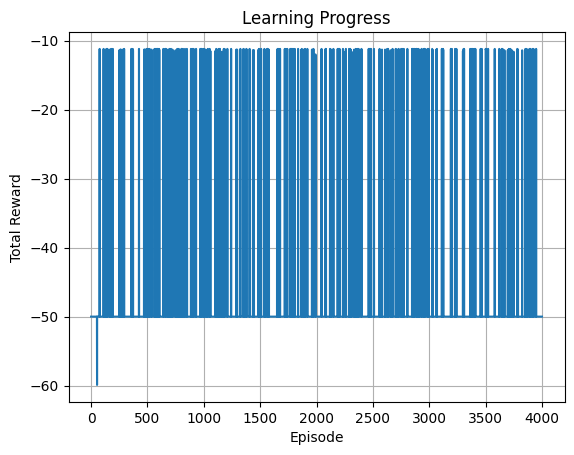

In [90]:
plt.plot(episode_rewards)
plt.title('Learning Progress')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

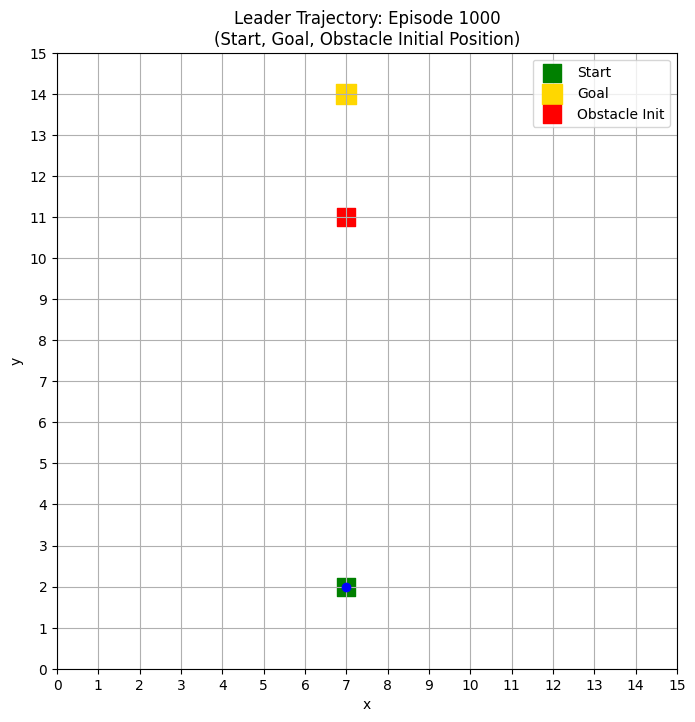

In [91]:
#エージェント（リーダー）の経路を可視化
if len(leader_paths) >= 1000:
    path_5000 = np.array(leader_paths[3998])  # 0-indexed

    # 環境を初期化して障害物の初期位置、スタート、ゴールを取得
    env_vis = Environment()
    obstacle_init_pos = np.array(env_vis.obstacle_pos)  # [x, y]
    start_pos = np.array(env_vis.s_pos)  # [x, y]
    goal_pos = np.array(env_vis.g_pos)    # [x, y]

    plt.figure(figsize=(8, 8))
    # 経路
    plt.plot(path_5000[:, 1], path_5000[:, 0], marker='o', color='b', )
    # スタート地点
    plt.scatter([start_pos[1]], [start_pos[0]], color='green', marker='s', s=150, label='Start')
    # ゴール地点
    plt.scatter([goal_pos[1]], [goal_pos[0]], color='gold', marker='s', s=200, label='Goal')
    # 障害物の初期位置
    plt.scatter([obstacle_init_pos[1]], [obstacle_init_pos[0]], color='red', marker='s', s=150, label='Obstacle Init')

    plt.title('Leader Trajectory: Episode 1000\n(Start, Goal, Obstacle Initial Position)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.xlim(0, 15)
    plt.ylim(0, 15)
    plt.xticks(np.arange(0, 16, step=1))
    plt.yticks(np.arange(0, 16, step=1))
    plt.legend()
    plt.show()
else:
    print("leader_pathsに5000エピソード分のデータがありません。")
